# Train the Normalizing Flow Model

### Import Modules

In [13]:
# external modules
import torch
from torch.utils.data import DataLoader
from pytorch_lightning.trainer import Trainer
import numpy as np
from torch.distributions import Uniform
import matplotlib.pyplot as plt
import os

# internal modules
from normalizing_flow_model import Flow1d
from dataset_NF import ExampleDataset

## 1) Generate Data
Data from two mixed gaussian with equal parts to the total distribution. A histogram is shown after the training procedure.

In [14]:
dataset = ExampleDataset(2000)
dataloader = DataLoader(dataset=dataset, batch_size=128, shuffle=True)

## 2) Train the Model

Training the model with specific number of components. More components, lead to more complex training procedure. Components must be at least the number true underlying distributions.

In [15]:
flow = Flow1d(n_components=2)
trainer = Trainer(max_epochs=100)
trainer.fit(flow, dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:307: LightningDeprecationWarning: The `LightningModule.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `LightningModule.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(

  | Name | Type | Params
------------------------------
------------------------------
6         Trainable params
0         Non-trainable params
6         Total params
0.000     Total estimated model params size (MB)
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this

Training: 0it [00:00, ?it/s]

## 3) Plot the Model
Plot the learned distribution and the underlying converting (invertible function).

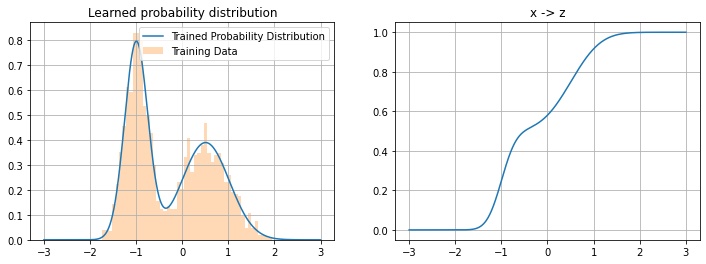

In [16]:
target_distribution = Uniform(0, 1)
x = np.linspace(-3,3,1000)
z, dz_by_dx = flow(torch.FloatTensor(x))
px = (target_distribution.log_prob(z) + dz_by_dx.log()).exp().detach().numpy()

_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].grid(), axes[1].grid()
_ = axes[0].plot(x,px, label="Trained Probability Distribution")
_ = axes[0].hist(dataloader.dataset.array, bins=50, density=True, label="Training Data", alpha=0.3)
_ = axes[0].set_title('Learned probability distribution')
_ = axes[0].legend()

_ = axes[1].plot(x,z.detach().numpy())
_ = axes[1].set_title('x -> z')

## 4) Loss of the Model
Loss of the training procedure after each epoch.

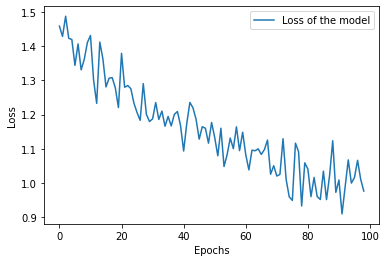

In [17]:
smoothing_factor = 1
plt.plot(np.arange(0, len(flow.total_loss), smoothing_factor),flow.total_loss[::smoothing_factor], label="Loss of the model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## 5) Save the Model

In [18]:
# path to save parameters from training
PATH = "trained_models/NF_1d.pth"
if not os.path.exists(os.path.dirname(PATH)):
    os.mkdir(os.path.dirname(PATH))

torch.save(flow.state_dict(), PATH)
print(f"Saved the model dictionary under {PATH}. Exiting.")

Saved the model dictionary under trained_models/NF_1d.pth. Exiting.
